Table of contents:

`*` means completed

- Tensors and rank *
- Stochastic Gradient Descent *
- Back Propagation *
- Other optimizers (Adam) *
- ReLu *
- Softmax *
- Momentum * 
- Exponentially weigthed averages * 
- Weight Decay *
- RMS Prop *
___
- Dropout
- Batch Normalization
- Residual Networks
- Dense Networks
- Generative Adversarial Networks

### Vocab

Training set: Data fed to the model during training, from this data the model extracts features and makes predictions. 

Validation set: Data set aside from training, that is used to validate whether the model extracted general features useful for making predictions, and to help avoid the model from learning the characteristics of one particular image or set of images. 

- Learning rate: The number that we multiply our gradient by, to decide how much to update the weights. Slower learning rate, update less. Faster learning rate, update more. Select learning rate prior to training.

- Epoch: One complete run through all of our images. Lots of epochs, looking at images lots of times. With this, there's a larger chance of overfitting. 

- Batch: Use all your data to compute the gradient during one iteration.

- Minibatch: Only take a subset of all your data during one iteration. Each subset is used to compute the gradient.

- Gradient Descent: Iterative algorithm (takes steps, each epoch) used to find the weights that give us the lowest possible loss, or the global minimum of the function. [Example Diagram @ 3:30](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3Db4Vyma9wPHo&psig=AOvVaw1LinMUBZQEvrTip3cmD37l&ust=1610487168503000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCIDXxK7qlO4CFQAAAAAdAAAAABAD) You want to optimize your network with weights that give you the most accurate predictions, or have the lowest loss, as dictated by the loss function you selected.

- SGD: Gradient descent, using minibatches.

- Model / Architecture: Kind of mean the same thing! An architecture could be something as simple as `y = xa`, it's just a linear equation. The architecture is the mathematical function you're fitting the parameters to. 

- Parameters: Parameters, or coefficients, or weights, are the numbers you're updating. 

- Loss function: Tells you how far away or how close you are to the correct answer.

- Regularization: Making sure model not only works well on data its seen, but on data it hasn't yet seen. Where validation set comes in. Other regularization techniques include implementing dropout and batch normalization, discussed in further detail below.

For classification problems, we use *cross entropy loss*, also known as *negative log likelihood loss*. This penalizes incorrect confident predictions, and correct unconfident predictions.


In [1]:
from fastai.basics import *
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

# Tensors and rank
A rank 1 tensor is a vector 
```Python 
tensor([a, b, c])
```

A rank 2 tensor is a matrix, it has both *rows and columns*
```Python
tensor([[a, b, c], [d, e, f]])
```

Tensors can have multiple channels, or matrices that are stacked in succession to represent different features of the image data. For example, the colors red, blue and green could comprise 3 channels of a tensor, representing the color makeup of an image.

You can index with the special value [None] or use unsqueeze() to convert a 1-dimensional array into a 2-dimensional tensor (although one of those dimensions has value 1).

```Python
c = tensor([10.,20,30]); c

c.unsqueeze(0)

c[None] # this adds a leading axis
c[:,None] # this adds a trailing axis
```

In [19]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [4]:
c[None].shape

torch.Size([1, 3])

In [5]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [6]:
c.unsqueeze(0).shape

torch.Size([1, 3])

In [7]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [8]:
c[:,None].shape

torch.Size([3, 1])

# Stochastic Gradient Descent = Gradient Descent, with mini batches!

You want to find **parameters** (weights) `a` such that you minimize the *error* between the points and the line `x@a`. Note that here `a` is unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**.

**Each neural network is a linear equation**, but instead of a handful of vectors, there are a million plus - this is an architecture, in the same way a linear equation with two vectors is an architecture. The parameters are like the coefficients! 

We would like to find the values of `a` that minimize `mse_loss`.

----

**Gradient descent** is an **algorithm that minimizes functions**. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient. **If the function is loss over epochs, the gradient descent works to minimize loss.**

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

**The gradient is the slope of the function that has the lowest mean squared error, otherwise known as the derivative!**

`loss.backward()` calcualtes the derivative, and stores it in grad or gradient

Subtracts the gradients, because we want the loss to be small 

Learning Rate - the thing that we multiply by the gradient `lr * grad`

Why is there any lr at all? Quadratic; how do you find where the function is at it's lowest point.

After calculating the gradient, determine which direction makes it go down? Which direction makes the gradient flatten?? 

**Want it to be a large enough step to not have to do so many calculations, but small enough when close to the right answer so that you don't totally miss the correct answer.**

In [14]:
n = 100
x = torch.ones(n,2)
# tell pytorch to create a tensor of n by 2
# since we passed in 2 things, get a rank 2 tensor
# number of rows n, number of columns 2
# torch.ones means that every single number in the matrix is 1
x[:,0].uniform_(-1.,1)
# can index into it, and put a colon. Colon means that every single value on that dimension 
# this means EVERY ROW of COLUMN ZERO
# in PyTorch - every time you have a function with an underscore, means that don't return to me a uniform random number
# instead, replace it with the result of the function. 
# Takes column zero, replaces it with a uniform random number between -1 and 1
x[:5]
# print out the first five rows

tensor([[-0.1854,  1.0000],
        [-0.7723,  1.0000],
        [ 0.5254,  1.0000],
        [ 0.6546,  1.0000],
        [-0.8878,  1.0000]])

In [26]:
a = tensor([-1.,1])

In [17]:
y = x@a + 0.25*torch.randn(n) # this is a matrix product of tensor x and tensor a

In [19]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [20]:
# Gradient Descent Function!

def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

In [21]:
lr = 1e-1
for t in range(100): update()

tensor(0.0524, grad_fn=<MeanBackward0>)
tensor(0.0520, grad_fn=<MeanBackward0>)
tensor(0.0519, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)


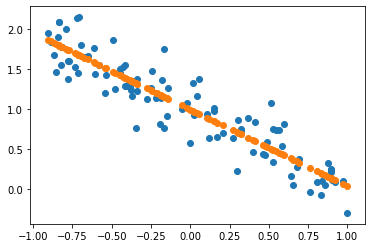

In [22]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],x@a.detach());

In [23]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [27]:
a = nn.Parameter(a)

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@a.detach())
plt.close()

def animate(i):
    update()
    line.set_ydata(x@a.detach())
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

Wikipedia on Gradient Descent:
Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent. Conversely, stepping in the direction of the gradient will lead to a local maximum of that function; the procedure is then known as gradient ascent.

Stochastic gradient descent is still a way to take steps towards the local minimum of a differentiable function, just do it interatively instead of all at once. Use minibatches, **then average across all minibatches when calculating loss**

# Back Propagation

Take the loss function between the actual targets and the output of the final activations, calculate the gradients with respect to the parameter matrices, and **UPDATE the weights by subtracting learning rate times the gradient.**

`Back_Prop = weights -= weights.grad * learning_rate`

Calculate the gradients using SGD, then pass back the gradients in order to update the parameter matrices of the network with new weights based on how well you did that epoch, otherwise known as the loss, based on whatever loss function you chose to implement!

# Activation functions: ReLu and Softmax

Activations are the "other numbers" in a neural network. Unlike the parameter matrices, these are not updated by SGD and back propagation (or other optimization algorithm), instead these remain unchanged and transform the values obtained by the updated weights into new vectors or tensors. 

#### ReLu stands for "Rectified Linear Unit"

Sounds cool, all it really means is **take anything that's negative, and make it zero**. This activation function is used commonly **between the layers of a neural network**, in a sequence such as 

- parameter tensor
- ReLu
- batch normalization
- dropout

- ... repeat


#### Softmax

Softmax is an activation function designed to convert a tensor of final predictions from a neural network into a vector between 0 and 1, with all values that sum to 1. 

In [34]:
#How to Softmax
import numpy as np

preds = [2.0, 1.0, 0.1]
print("Original vector: " + str(preds))

exponents = [np.exp(i) for i in preds] # e^i for all i (values) in the predictions vector using list comprehension
print("Exponent vector: " + str(exponents), "\n")

print("Does this vector sum to one?")

if sum(exponents) == 1:
    print("Yes")
else:
    print("No")

Original vector: [2.0, 1.0, 0.1]
Exponent vector: [7.38905609893065, 2.718281828459045, 1.1051709180756477] 

Does this vector sum to one?
No


In [36]:
sum_of_exps = sum(exponents) # use this to normalize the exponents vector by dividing each value by the sum

softmax = [j/sum_of_exps for j in exponents] # divide all j in the vector exponents by sum_of_exps value
print(softmax, "\n")

print("Does this vector sum to one?")

if sum(softmax) == 1:
    print("Yes")
else:
    print("No")

[0.6590011388859679, 0.2424329707047139, 0.09856589040931818] 

Does this vector sum to one?
Yes


# Exponentially weighted moving averages

[This Andrew Ng video explains it really well, in 5 minutes ](https://www.youtube.com/watch?v=lAq96T8FkTw)

Say you want to find the trend of the change in temperature over a year (in this case, will probably have a normal distribution). 

In [16]:
beta = 0.9
b = 1 - beta

theta_1 = 25 # theta is the temperature from the first day
theta_2 = 30 # temperature on second day

V_not = 0 # This is the starting value

V1 = (beta * V_not) + (b * theta_1)
V2 = (beta * V1) + (b * theta_2)

V1

2.4999999999999996

In [17]:
V2

5.249999999999998

In [6]:
days_averaged = 1/(1-beta)

In [7]:
days_averaged

10.000000000000002

When beta is large, average over a larger distance of the curve. This makes the curve **smoother**, but **latent** in its reaction to a change in the data - as a result, could be shifted over from where the curve lies.

When beta is small, plotted averages are **bumpier**, but **more adaptable**. Not smooth, but, sticks to the data you're modeling better because it is more responsive to changes and reacts quicker. Closer to the actual curve.

# Momentum: Implementing exponentially weighted moving averages, now over past gradients!

Momentum replaces gradients with a leaky average over past gradients. **This accelerates convergence significantly.**

It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.

**Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.**

### The effective number of gradients is given by  1/(1−𝛽)  due to exponentiated downweighting of past data.

In the case of convex quadratic problems this can be analyzed explicitly in detail.

**Implementation is quite straightforward but it requires us to store an additional state vector (momentum  𝐯 ).

This is momentum as in exponentially weighted moving average

## Don't actually take the mean and stdev of every mini batch; if we did, would vary so much that it would be very hard to train.

**Instead, take an exponentially weighted moving average of the mean and stdev**

Vary amount of momentum in a batch normalization layer
If you use a **smaller** number, **means that the mean and standard deviation will vary less** from mini batch to mini batch
**This will have less of a regularization effect.**

**Larger** number means **variation will be greater** from mini batch to mini batch
This will have **more of a regularization effect**

## Momentum - adds customizable regularization!

*More batch norm, can have a higher learning rate!

These regularization tools allow you to build models with more parameters, larger, and train at a higher learning rate

**Always want weight decay, also want a bit of dropout, and always want batch normalization!**

___

# RMS Prop

Like momentum, have an exponentially weighted moving average, not of the gradient updates, but of - f/8 squared. Or, teh gradient squared. 

`(previous value) * 0.9 + (gradient)^2 * 0.1 # compare this with exp weighted moving avg py example!`

If the gradient is really small, and consistenly really small, then this will be a small number.
If the gradient is highly volatile, it'll be a big number, or big all the time, big number. 

Do both = do both RMS prop and momentum. This is the Adam optimizer! (compare with plain SGD)

[Useful article](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)

Root Mean Square Propagation (RMSProp maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight **(e.g. how quickly it is changing)**. This means the algorithm does well on online and non-stationary problems **(e.g. noisy)**.

The central idea of RMSprop is keep the moving average of the squared gradients for each weight. And then we divide the gradient by square root the mean square. Which is why it’s called RMSprop(root mean square). 

We adapt learning rate by dividing by the root of squared gradient, but since we only have the estimate of the gradient on the current mini-batch, **instead we need to use the moving average of it**. Default value for the moving average parameter that you can use in your projects is 0.9. It works very well for most applications. In code the algorithm might look like this:

In [ ]:
import numpy as np 

grad_squared = 0
num_iterations = 100
x = np.array([1,3,4,6,7,19,35,68])
y = np.array([10,14,15,18,19,35, 48, 72])

def compute_gradients(x, y):
    # write soemthing to compute the gradients, change in y over change in x
    
for i in num_iterations:
    dw = compute_gradients(x, y) # dy/dx
    grad_squared = 0.9 * grads_squared + 0.1 * (dw * dw) # this is the gradient, squared!
    w = w - (lr / np.sqrt(grad_squared)) * dw

# Weight Decay

**Weight decay is important tool - Can make giant neural networks and still avoid over-fitting by adding more weight decay. Could also use really small datasets with moderately large sized models and avoid over-fitting with weight decay.**

In [20]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    
    ## weight decay - this IS weight decay, these two lines below are it
    
    w2 = 0.  ## why is this 0. ??????
    for p in model.parameters(): w2 += (p**2).sum() ## add to 0. the sum of squared weights!
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd # multiply sum of squared weights by weight decay
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

# return loss
## if you call .item() on a scalar tensor
# TURNS IT INTO AN ACTUAL NORMAL PYTHON NUMBER

# Keep this in mind! Could shorten your code to turn tensor into numpy array!


# all weight decay does is subtracts some constant times the 
# weights every time we process a batch!


# Other optimizers in Deep Learning: Adam

SGD is not the only optimization algorithm; this is an active area of deep learning research!

Adam is an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks. 

## Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. 

It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. 

Adam is an *adaptive learning rate method*, which means, it computes **individual learning rates for different parameters/weights**. Its name is derived from adaptive moment estimation, and the reason it’s called that is because Adam uses estimations of first and second moments of gradient to adapt the learning rate for each weight of the neural network (what is moment ? N-th moment of a random variable is defined as the expected value of that variable to the power of n).

Adam is different to classical stochastic gradient descent.

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

### Adam realizes the benefits of both AdaGrad and RMSProp.

**Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).**

### Adam calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

[Original paper](https://arxiv.org/abs/1412.6980)

[Helpful Article](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

[Adam Optimization from Scratch](https://machinelearningmastery.com/adam-optimization-from-scratch/)

___

# Dropout
#### A type of regularization technique

A standard fully connected network: each hidden layer, with multiple arrows coming in, represents a sum. So, this activation in hidden layer is the **sum** of all of these inputs times all of these activations. 

Dropout: Throw that away. At random, through away some percentage fo the activations. Not the weights, just the activations. When you throw away some of the activations, also throw away some of the inputs that the activation was connected to 

For each mini-batch, throw away a different sub-set of activations. How many do we throw away? Throw away each with a probability of P, with a common value of 0.5

What does that mean? Not only has this deleted at random some hiddne layers, but also deleted some of the inputs as well. Deleting inputs is unusual, normally just delete activations in the hidden layers. 

What does this do? Every time we have a minibatch that goes through, at random, throw away some of the activations. For the next mini batch, put them back and throw away some differnet ones. Means that there's no one activation that can memorize some part of the input.

That, where one or more activations in the hiddne layers memorizes distinct un-generalizable features of the input, cannot happen when you with some random probability delete them when processing each of the minibatches

Noisy activations, can afford to use bigger model, i.e. more parameters!

## ps: this is the p-value for the dropout of each layer
Just pass in a list, or an int, and will convert that to a list with that value everywhere

## Can always pass in your own list to get the dropout you want!

training time - turn on dropout
test time - turn off dropout
So that we can't cause it to overfit when we're doing inference

Pytorch does this for you

Can write your own dropout layer!

# Special dropout on embedding layer, why???

see lesson 4 tabular comments below the emb_dropout func of the 
forward function

```Python
TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)
```

# Batch Normalization

How does batch norm help optimization??
Doesn't reduce covariate shift, but does this:

Can increase your learning rate with batch normalization, because big bumps represent times that you're at risk of weights jumping off into some awful part of weight space it can never get out of

Less bumpy (i.e. plus batch norm), more likely to avoid this risk and can train with a higher learning rate

Algorithm - takes mini batch

Layer that takes in activations

find the mean 

then, find the variance

then, normalize - the values, minus the mean, divided by the standard deviation

take those values, add a vector of biases, and add another thing like a bias term, but **instead of adding it, multiply by it**

gamma and beta, learnable parameters

multicaplicative bias layer

why is that able to achieve result?

### How does it work

```y_hat = f(w1, w2, ...  wn, x)```

```loss = sum(y - y_hat)^2```

Example: movie review - want between 1 and 5

right now, -1 and 1

scale and mean are off

### Try to come up with a new set of weights that cause the spread to increase and the mean to increase as well. 

Would take a long time, bumpy!

```y_hat = f(w1, w2, ...  wn, x) * g + b```

in order to increase scale, g has a direct gradient to increase the scale, to change the mean, that number has a direct gradient to change the mean 

## Works by adjusting weights to change the mean and variance of the mini batch to what the actual input data looks like, so that predictions are more likely to also fit this distribution i.e. be more accurate